## 제주도 버스 탑승객 클러스터링 
#### 모듈 및 파일 import 

In [1]:
import pandas as pd
import os
import dask.dataframe as dd
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import datetime
import missingno as msno
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from dask.diagnostics import ProgressBar
ProgressBar().register()
#df.count().compute(scheduler='processes', num_workers=4)

In [4]:
# 값의 길이로 인한 생략을 없애는 옵션
pd.options.display.float_format = '{:.2f}'.format

# 기타옵션 - 경고 출력 없애기 
import warnings #경고 미출력
warnings.filterwarnings('ignore')

In [5]:
bus_2018 = dd.read_csv("data/버스 승객별 이용 현황_2018.csv",
                 dtype={'getoff_datetime': 'float64','getoff_station_id': 'float64'})
bus_2019 = dd.read_csv("data/버스 승객별 이용 현황_2019.csv",
                 dtype={'getoff_datetime': 'float64','getoff_station_id': 'float64'})

In [6]:
bus_total = dd.concat([bus_2018, bus_2019], axis=0)

#### 승차 횟수 구하기 

In [7]:
user_counts = bus_total["user_id"].compute().value_counts()
user_counts = pd.DataFrame(user_counts)
user_counts.rename(columns={"user_id":"counts"}, inplace=True)
user_counts["order"] = list(range(len(user_counts)))
user_counts.head()

[########################################] | 100% Completed |  1min 42.4s


,counts,order
b967fc6b1e8464ca95dbf7a89c5245cfa06e33c9b114efe99adfc9939c1197e1,4618,0
a7dc65282441f85e76a4a8251d8c40f6dc1cf703656ebb75016c2ca499efe963,3964,1
27deb4dfc30c072fed5a061988e633927f5a74602f8df7fefd2b6ff7cba278c0,3856,2
49be7f71914af1d1db7ac19536b373ddd27036a91f2fcd6204a7d32078e2246a,3754,3
5156d3148998cb8b13077df6f25e41d7e33540a8a2c63d75e3e4744ae751d053,3715,4


In [11]:
bus_total["base_date"] = bus_total["base_date"].astype("str")
bus_total["datetime"] = dd.to_datetime(bus_total["base_date"])

In [12]:
bus_total.head()

[########################################] | 100% Completed |  0.6s


,base_date,user_id,route_id,route_name,route_no,geton_datetime,geton_station_id,geton_stataion_name,geton_station_longitude,geton_station_latitude,getoff_datetime,getoff_station_id,getoff_station_name,getoff_station_longitude,getoff_station_latitude,user_type,user_count,pt_year,pt_month,datetime
0,20180701,32e671337bb82b0fbeea7068456e4b8f43719ed28c8a17...,24300000,465-7(제주도립미술관~제주도립미술관입구),465-7,20180701154648,150,시외버스터미널,126.51,33.50,20180701160732.00,2956.00,원노형,126.48,33.49,경로,1,2018,7,2018-07-01
1,20180701,42e00baaa901cedfcf944dfd05da453be59f133c936fdd...,24310000,466-1(축산마을~축산진흥원입구),466-1,20180701220924,318,연동주민센터,126.50,33.49,20180701221420.00,2956.00,원노형,126.48,33.49,일반,1,2018,7,2018-07-01
2,20180701,cd2b27a6a5e62ee604742eaaf39bddb16070ec4123df39...,23050000,315-2(국제여객선터미널~수산리),315-2,20180701122425,318,연동주민센터,126.50,33.49,20180701123251.00,2956.00,원노형,126.48,33.49,일반,1,2018,7,2018-07-01
3,20180701,4ec68c3c529dd3fcba4837c1987be581658805aa449302...,24300000,465-7(제주도립미술관~제주도립미술관입구),465-7,20180701070345,318,연동주민센터,126.50,33.49,20180701070808.00,2956.00,원노형,126.48,33.49,일반,1,2018,7,2018-07-01
4,20180701,777dcac689d2d1018e03349ae4b406051c6b2a1aa8d9f3...,24300000,465-7(제주도립미술관~제주도립미술관입구),465-7,20180701163538,187,은남동,126.49,33.49,20180701163816.00,2956.00,원노형,126.48,33.49,일반,1,2018,7,2018-07-01


#### 대중교통 이용 기간 구하기 :  (가장 최근의 승차일) - (첫 승차일) 

In [13]:
mindate = bus_total[["user_id", "datetime"]].groupby("user_id").min().compute(scheduler="processes", num_workers=8)
maxdate = bus_total[["user_id", "datetime"]].groupby("user_id").max().compute(scheduler="processes", num_workers=8)

[########################################] | 100% Completed |  2min 21.0s
[########################################] | 100% Completed |  2min 22.2s


In [14]:
mindate.head()

,datetime
user_id,
000049db048f726c0aff98cf3af050d435ef69ac5164ad56cf4b3832c7f9cb2f,2018-07-02
0000667058c791cad5a33a0859f54cc671dba188896a043db8f792260d7803db,2018-07-01
000099ebe00c235984f58f911118780cdf854679814cdcca3afe4225795eed02,2018-07-02
0000b12eadf6a5cdbfb34502360a0a946f1a40726355e7543beb78429765ff35,2018-07-02
000152c1a8a525d9d8b7adec47cd2964f715e22f73930caeba2b4f026cabc3c5,2018-07-02


In [15]:
maxdate.head()

,datetime
user_id,
000049db048f726c0aff98cf3af050d435ef69ac5164ad56cf4b3832c7f9cb2f,2019-09-12
0000667058c791cad5a33a0859f54cc671dba188896a043db8f792260d7803db,2019-11-10
000099ebe00c235984f58f911118780cdf854679814cdcca3afe4225795eed02,2018-09-10
0000b12eadf6a5cdbfb34502360a0a946f1a40726355e7543beb78429765ff35,2018-08-28
000152c1a8a525d9d8b7adec47cd2964f715e22f73930caeba2b4f026cabc3c5,2019-11-09


In [16]:
mindate.reset_index(inplace=True)
maxdate.reset_index(inplace=True)

In [17]:
df_date = pd.merge(left=mindate, right=maxdate, on="user_id", how="inner")
df_date["period"] = df_date["datetime_y"] - df_date["datetime_x"]

In [18]:
df_date.head()

,user_id,datetime_x,datetime_y
0,000049db048f726c0aff98cf3af050d435ef69ac5164ad...,2018-07-02,2019-09-12
1,0000667058c791cad5a33a0859f54cc671dba188896a04...,2018-07-01,2019-11-10
2,000099ebe00c235984f58f911118780cdf854679814cdc...,2018-07-02,2018-09-10
3,0000b12eadf6a5cdbfb34502360a0a946f1a40726355e7...,2018-07-02,2018-08-28
4,000152c1a8a525d9d8b7adec47cd2964f715e22f73930c...,2018-07-02,2019-11-09


In [21]:
df_date["period"].describe()

count                        2400594
mean      90 days 03:30:39.315769350
std      155 days 14:56:15.467178470
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                  2 days 00:00:00
75%                118 days 00:00:00
max                548 days 00:00:00
Name: period, dtype: object

In [27]:
print(len(user_counts), len(df_date))

2400594

In [29]:
user_counts.reset_index(inplace=True)

In [30]:
user_info = pd.merge(left =user_counts, right=df_date, left_on="index", right_on="user_id")

In [31]:
user_info.drop(columns=["order", "user_id"], axis=1, inplace=True)

In [32]:
user_info.head()

,index,counts,datetime_x,datetime_y,period
0,b967fc6b1e8464ca95dbf7a89c5245cfa06e33c9b114ef...,4618,2018-07-01,2019-12-31,548 days
1,a7dc65282441f85e76a4a8251d8c40f6dc1cf703656ebb...,3964,2018-07-01,2019-12-31,548 days
2,27deb4dfc30c072fed5a061988e633927f5a74602f8df7...,3856,2018-07-01,2019-12-31,548 days
3,49be7f71914af1d1db7ac19536b373ddd27036a91f2fcd...,3754,2018-07-01,2019-12-31,548 days
4,5156d3148998cb8b13077df6f25e41d7e33540a8a2c63d...,3715,2018-07-02,2019-12-31,547 days


In [33]:
user_info["period_int"] = user_info["period"].dt.days

### KMeans Clustering  
- 모든 유니크 승객들의 총 승차 횟수, 승차 기간을 기준으로 KMeans Clustering 진행 
- n_clusters = 2

In [34]:
model = KMeans(n_clusters=2)
model.fit(user_info[["counts", "period_int"]])

KMeans(n_clusters=2)

In [35]:
kmeans = pd.DataFrame(model.predict(user_info[["counts", "period_int"]]), columns=["cluster"])
user_info = pd.concat([user_info, kmeans], axis=1)
user_info.head()

,index,counts,datetime_x,datetime_y,period,period_int,cluster
0,b967fc6b1e8464ca95dbf7a89c5245cfa06e33c9b114ef...,4618,2018-07-01,2019-12-31,548 days,548,1
1,a7dc65282441f85e76a4a8251d8c40f6dc1cf703656ebb...,3964,2018-07-01,2019-12-31,548 days,548,1
2,27deb4dfc30c072fed5a061988e633927f5a74602f8df7...,3856,2018-07-01,2019-12-31,548 days,548,1
3,49be7f71914af1d1db7ac19536b373ddd27036a91f2fcd...,3754,2018-07-01,2019-12-31,548 days,548,1
4,5156d3148998cb8b13077df6f25e41d7e33540a8a2c63d...,3715,2018-07-02,2019-12-31,547 days,547,1


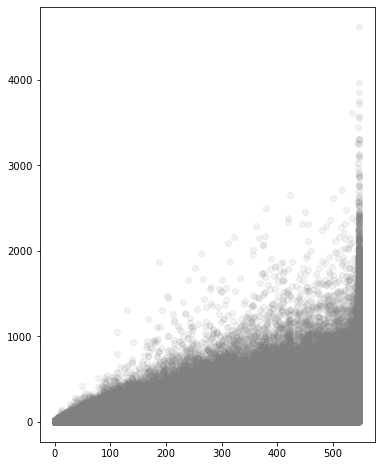

In [169]:
plt.figure(figsize=(6, 8))
plt.scatter(user_info["period_int"], user_info["counts"],
           alpha=0.1, 
           c = "grey")
plt.show()

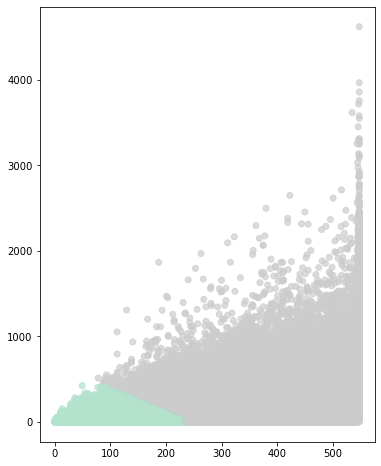

In [164]:
plt.figure(figsize=(6, 8))
plt.scatter(user_info["period_int"], user_info["counts"],
           c=user_info["cluster"], alpha=0.7, 
           cmap = "Pastel2")
plt.show()

- 클러스터링 결과 
- 0번 클러스터 : 197만명, 1번 클러스터 : 42만명
- 2018, 2019 당시 제주도민의 수가 60만명대 후반

In [37]:
user_info["cluster"].value_counts()

0    1972554
1     428040
Name: cluster, dtype: int64

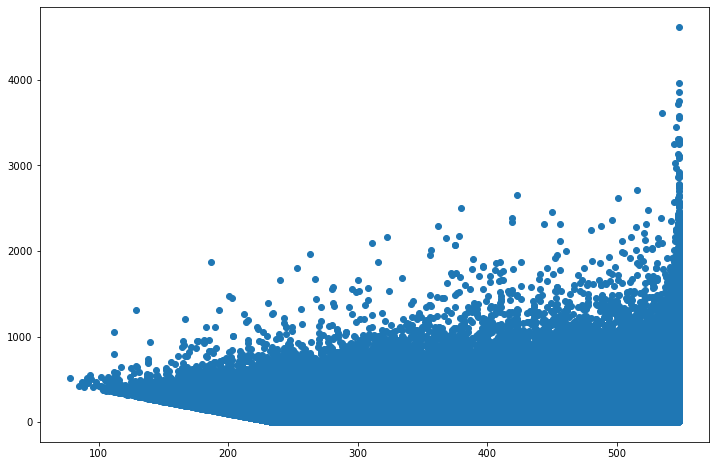

In [38]:
plt.figure(figsize=(12, 8))
plt.scatter(user_info[user_info["cluster"] == 1]["period_int"], 
            user_info[user_info["cluster"] == 1]["counts"],
          )
plt.show()

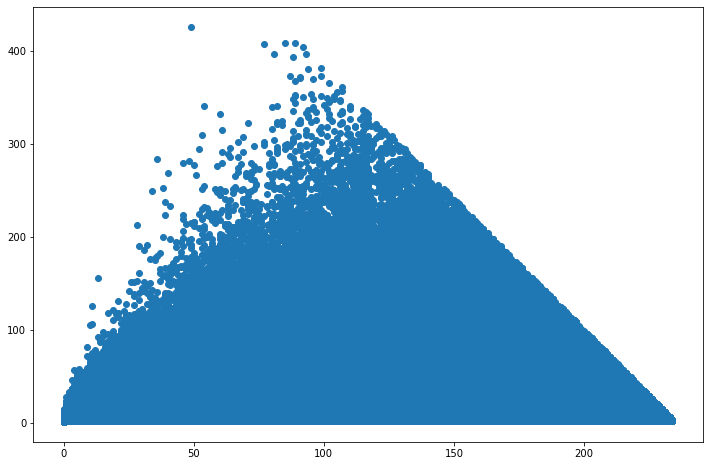

In [39]:
plt.figure(figsize=(12, 8))
plt.scatter(user_info[user_info["cluster"] == 0]["period_int"], 
            user_info[user_info["cluster"] == 0]["counts"],
          )
plt.show()

In [40]:
# 클러스터별 유저 id 리스트 저장 
tourist = list(user_info[user_info["cluster"] == 0]["index"])
citizen  = list(user_info[user_info["cluster"] == 1]["index"])

In [89]:
# 클러스터별 데이터프레임 구분 
tourist_df = bus_total[bus_total["user_id"].isin(tourist)]
jeju_df = bus_total[bus_total["user_id"].isin(citizen)]

In [42]:
#tourist_info = tourist_df[["base_date", "user_count"]].groupby("base_date").sum()

In [43]:
#citizen_info = jeju_df[["base_date", "user_count"]].groupby("base_date").sum()

In [44]:
#pd.DataFrame(tourist).to_csv("data/tourist_list.csv", encoding="utf-8-sig")

In [45]:
#pd.DataFrame(citizen).to_csv("data/citizen_list.csv", encoding="utf-8-sig")

In [46]:
#구분된 클러스터의 정보 
#클러스터 0의 평균 탑승 횟수와 기간이 훨씬 적다는 것을 알 수 있다 
user_info[["counts", "period_int", "cluster"]].groupby("cluster").mean()

,counts,period_int
cluster,,
0,8.80,24.32
1,139.69,393.47


In [47]:
tourist_ls = pd.read_csv("data/tourist_list.csv", encoding="utf-8-sig")
citizen_ls = pd.read_csv("data/citizen_list.csv", encoding="utf-8-sig")



In [48]:
tourist_ls = tourist_ls.drop(columns="Unnamed: 0", axis=1)
citizen_ls = citizen_ls.drop(columns="Unnamed: 0", axis=1)

In [49]:
citizen_ls.head()

,0
0,b967fc6b1e8464ca95dbf7a89c5245cfa06e33c9b114ef...
1,a7dc65282441f85e76a4a8251d8c40f6dc1cf703656ebb...
2,27deb4dfc30c072fed5a061988e633927f5a74602f8df7...
3,49be7f71914af1d1db7ac19536b373ddd27036a91f2fcd...
4,5156d3148998cb8b13077df6f25e41d7e33540a8a2c63d...


In [50]:
#전체에서 10퍼센트만 샘플링 
tour_sample = list(tourist_ls.sample(frac=0.1, random_state=13)["0"].values)

In [52]:
tour_df = bus_total[bus_total["user_id"].isin(tour_sample)].groupby("base_date", "user_counts").sum().compute()

[########################################] | 100% Completed |  3min 19.9s


In [53]:
city_sample = list(citizen_ls.sample(frac=0.1, random_state=13)["0"].values)

In [54]:
citizen_df = bus_total[bus_total["user_id"].isin(city_sample)].groupby("base_date", "user_counts").sum().compute()

[########################################] | 100% Completed |  2min 45.9s


In [55]:
tour_df.reset_index(inplace=True)

In [56]:
tour_df["base_date"] = tour_df["base_date"].astype("str")

In [57]:
citizen_df.reset_index(inplace=True)
citizen_df["base_date"] = citizen_df["base_date"].astype("str")

#### 관광객 / 도민 나눠서 이용량 그래프 그려보기 
- x : 날짜, y : 버스 이용량

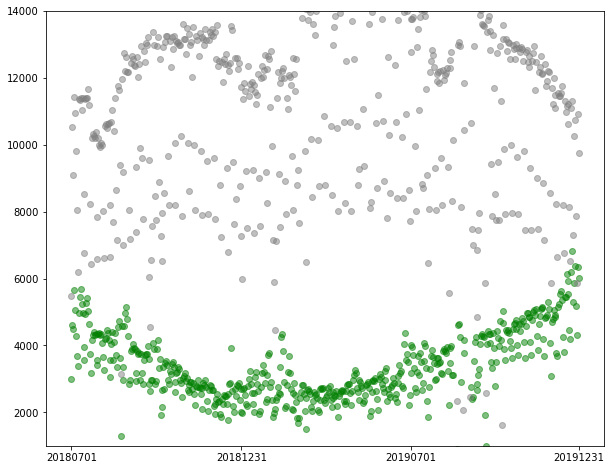

In [181]:
plt.figure(figsize=(10, 8))
plt.scatter(x = "base_date", 
            y = "user_count", 
            data = tour_df,
            alpha = 0.5,
            c = "green")

plt.scatter(x = "base_date", 
            y = "user_count", 
            data = citizen_df,
            alpha = 0.5,
            c = "grey")

plt.xticks(ticks = ["20180701", "20181231", "20190701", "20191231"])
plt.ylim([1000, 14000])
plt.show()

#### 기존 파일과 병합

In [59]:
#회귀분석용으로 만들어두었던 파일 가져옴 
reg_df = pd.read_csv("data/final_0513.csv", encoding="utf-8-sig")

In [60]:
reg_df.head()

,Unnamed: 0,base_date,airportbususer,bususer,tour,user_count
0,0,20180701,3910,30573,남,3933
1,1,20180701,3910,30573,동남,1832
2,2,20180701,3910,30573,동부중산간,212
3,3,20180701,3910,30573,동북,2797
4,4,20180701,3910,30573,북,6455


In [61]:
tour_df.head()

,base_date,route_id,geton_datetime,geton_station_id,geton_station_longitude,geton_station_latitude,getoff_datetime,getoff_station_id,getoff_station_longitude,getoff_station_latitude,user_count,pt_year,pt_month
0,20180701,71112940000,58524033326906888,263159066,366809.00,96940.25,40906281231399272.00,173704905.00,256482.64,67777.40,2996,5852200,20300
1,20180702,113095270000,90853521045537552,401965955,569478.17,150536.22,61954755591430624.00,197025569.00,388422.68,102665.09,4622,9085036,31514
2,20180703,108403840000,87624613049911808,393677856,549072.12,145136.24,60360483113589760.00,211440798.00,378395.10,100006.54,4481,8762156,30394
3,20180704,137695910000,110852607856995920,651032742,694905.09,183653.95,77917698712824832.00,342140612.00,488530.44,129095.53,5666,11084874,38451
4,20180705,123630690000,99208346474007584,489468910,622000.04,164400.75,67565000826495872.00,259882484.00,423600.96,111948.36,5062,9920488,34412


In [62]:
reg_df = reg_df[["base_date", "airportbususer"]]
reg_df["base_date"] = reg_df["base_date"].astype("str")

In [63]:
reg_df = pd.merge(left=reg_df, right=tour_df[["base_date", "user_count"]], on="base_date")

In [64]:
reg_df = reg_df.drop_duplicates(["base_date", "airportbususer", "user_count"])

In [65]:
reg_df = pd.merge(left=reg_df, right=citizen_df[["base_date", "user_count"]], on="base_date")

In [66]:
reg_df.rename(columns={"user_count_x" : "tourist", "user_count_y" : "citizen"}, inplace=True)

#### 이용량 구분해서 그리기 

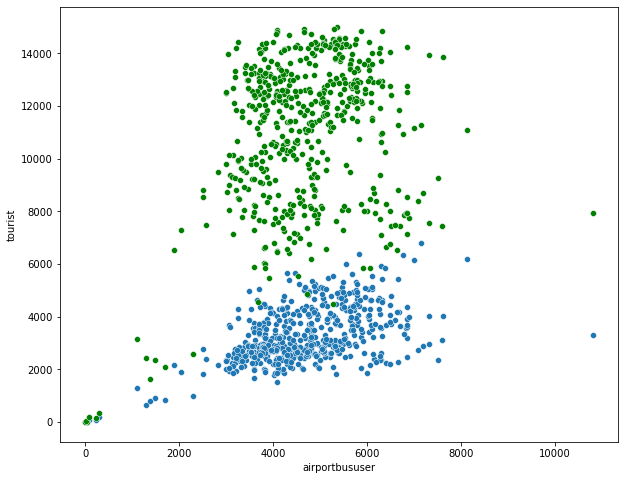

In [67]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x = "airportbususer", 
                y = "tourist", 
               data = reg_df, 
               )
sns.scatterplot(x = "airportbususer", 
                y = "citizen", 
               data = reg_df, 
               color = "g", 
               )


plt.show()

#### 관광객의 이용량에 대한 OLS

In [95]:
X = reg_df["airportbususer"]
X_add = sm.add_constant(X, has_constant = "add") 
y = reg_df["tourist"]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tourist   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     132.7
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.54e-26
Time:                        15:03:58   Log-Likelihood:                -3139.8
No. Observations:                 381   AIC:                             6284.
Df Residuals:                     379   BIC:                             6292.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1238.9493    183.638      6.747      0.000     877.872    1600.027
airportbususer     0.4425      0.038     11.522      0.000       0.367       0.518
==============================================================================
Omnibus:                        8.155   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.431
Skew:                           0.359   Prob(JB):                       0.0148
Kurtosis:                       2.878   Cond. No.                     1.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
y_pred = lm.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

853.1061014069554

#### 도민의 이용량에 대한 OLS

In [70]:
X = reg_df["airportbususer"]
X_add = sm.add_constant(X, has_constant = "add") 
y = reg_df["citizen"]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                citizen   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     56.94
Date:                Fri, 14 May 2021   Prob (F-statistic):           3.37e-13
Time:                        15:27:48   Log-Likelihood:                -3547.6
No. Observations:                 381   AIC:                             7099.
Df Residuals:                     379   BIC:                             7107.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7035.7126    535.526     13.138      0.000    5982.738    8088.687
airportbususer     0.8451      0.112      7.546      0.000       0.625       1.065
==============================================================================
Omnibus:                       27.593   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.208
Skew:                          -0.706   Prob(JB):                     1.01e-07
Kurtosis:                       2.809   Cond. No.                     1.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
reg_df[["airportbususer", "tourist", "citizen"]].corr()

,airportbususer,tourist,citizen
airportbususer,1.00,0.54,0.33
tourist,0.54,1.00,0.37
citizen,0.33,0.37,1.00


In [72]:
#inplace : bool, default False  (Not supported in Dask) Whether to return a new DataFrame. If True then value of copy isignored.
# 관광객 - 승차 정류장 기준 위도, 경도, 유저 수  
geton_df = tourist_df[["geton_station_longitude", "geton_station_latitude", "user_count"]]
# 승차 정류장 기준으로 유저 수를 sum -> 정류장 사용량을 보려고 
geton_df = geton_df.groupby(["geton_station_longitude", "geton_station_latitude"]).sum().reset_index()
# 사용량에 따라 색깔 변화를 주기 위한 값(0~1로 스케일링)
geton_df["scale"] = geton_df["user_count"] / geton_df["user_count"].max()
geton_df.compute()

[########################################] | 100% Completed |  9min 54.2s


,geton_station_longitude,geton_station_latitude,user_count,scale
0,126.16,33.31,250,0.00
1,126.18,33.28,48,0.00
2,126.18,33.34,63,0.00
3,126.18,33.32,407,0.00
4,126.18,33.32,794,0.00
...,...,...,...,...
5514,126.87,33.52,2,0.00
5515,126.27,33.39,1,0.00
5516,126.66,33.47,1,0.00
5517,126.62,33.26,1,0.00


In [73]:
# 하차 정류장 기준 위도, 경도, 유저 수  
getoff_df = tourist_df[["getoff_station_longitude", "getoff_station_latitude", "user_count"]]
# 하차 정류장 기준으로 유저 수를 sum -> 정류장 사용량을 보려고 
getoff_df = getoff_df.groupby(["getoff_station_longitude", "getoff_station_latitude"]).sum().reset_index()
getoff_df["scale"] = getoff_df["user_count"] / getoff_df["user_count"].max()
getoff_df.compute()

[########################################] | 100% Completed |  8min 36.7s


,getoff_station_longitude,getoff_station_latitude,user_count,scale
0,126.18,33.32,814,0.01
1,126.18,33.31,196,0.00
2,126.18,33.30,351,0.00
3,126.18,33.30,1070,0.01
4,126.18,33.30,533,0.00
...,...,...,...,...
5458,126.80,33.39,2,0.00
5459,126.82,33.54,112,0.00
5460,126.37,33.45,2,0.00
5461,126.68,33.49,8,0.00


In [75]:
#geton_df.compute().to_csv("data/tourist_geton.csv", encoding="utf-8-sig", index=False)

[########################################] | 100% Completed | 10min  6.9s


In [76]:
#getoff_df.compute().to_csv("data/tourist_getoff.csv", encoding="utf-8-sig", index=False)

[########################################] | 100% Completed |  9min 32.4s


In [90]:

#inplace : bool, default False  (Not supported in Dask) Whether to return a new DataFrame. If True then value of copy isignored.
# 도민 - 승차 정류장 기준 위도, 경도, 유저 수  
geton_df_city = jeju_df[["geton_station_longitude", "geton_station_latitude", "user_count"]]
# 승차 정류장 기준으로 유저 수를 sum -> 정류장 사용량을 보려고 

geton_df_city = geton_df_city.groupby(["geton_station_longitude", "geton_station_latitude"]).sum().reset_index()
# 사용량에 따라 색깔 변화를 주기 위한 값(0~1로 스케일링)
geton_df_city["scale"] = geton_df_city["user_count"] / geton_df_city["user_count"].max()
#geton_df_city.compute().to_csv("data/citizen_geton.csv", encoding="utf-8-sig", index=False)

[########################################] | 100% Completed |  4min  0.3s


In [91]:
geton_df_city.head()

[########################################] | 100% Completed |  4min  1.1s


,geton_station_longitude,geton_station_latitude,user_count,scale
0,126.16,33.31,369,0.00
1,126.17,33.29,79,0.00
2,126.17,33.33,454,0.00
3,126.17,33.28,209,0.00
4,126.18,33.28,164,0.00


In [93]:
# 하차 정류장 기준 위도, 경도, 유저 수  
getoff_df_city = jeju_df[["getoff_station_longitude", "getoff_station_latitude", "user_count"]]
# 하차 정류장 기준으로 유저 수를 sum -> 정류장 사용량을 보려고 
getoff_df_city = getoff_df_city.groupby(["getoff_station_longitude", "getoff_station_latitude"]).sum().reset_index()
getoff_df_city["scale"] = getoff_df_city["user_count"] / getoff_df_city["user_count"].max()
#getoff_df_city.compute().to_csv("data/citizen_getoff.csv", encoding="utf-8-sig", index=False)

[########################################] | 100% Completed |  4min  0.5s


In [94]:
getoff_df_city.head()

[########################################] | 100% Completed |  4min 11.9s


,getoff_station_longitude,getoff_station_latitude,user_count,scale
0,126.16,33.31,176,0.00
1,126.17,33.32,267,0.00
2,126.17,33.28,35,0.00
3,126.18,33.28,56,0.00
4,126.18,33.28,18,0.00


In [110]:
#1일전 공항에서 버스에 탑승한 사람 수의 컬럼 추가 
airport_1dayago = list(reg_df["airportbususer"])
airport_1dayago.insert(0, 0)
airport_1dayago = airport_1dayago[:-1]

In [113]:
#2일전 공항에서 버스에 탑승한 사람 수의 컬럼 추가 
airport_2dayago = list(reg_df["airportbususer"])
airport_2dayago.insert(0, 0)
airport_2dayago.insert(0, 0)
airport_2dayago = airport_2dayago[:-2]

In [115]:
reg_df["airport_-1"] = airport_1dayago
reg_df["airport_-2"] = airport_2dayago



In [116]:
reg_df.head()

,base_date,airportbususer,tourist,citizen,airport_-1,airport_-2
0,20180701,3910,2996,5480,0,0
1,20180702,4209,4622,10542,3910,0
2,20180703,3763,4481,9084,4209,3910
3,20180704,4472,5666,11422,3763,4209
4,20180705,3708,5062,10958,4472,3763


In [122]:
# OLS - columns : 공항에서 승차한 사람 
X = reg_df.iloc[2:,:]["airportbususer"]
X_add = sm.add_constant(X, has_constant = "add") 
y = reg_df.iloc[2:,:]["tourist"]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tourist   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     158.5
Date:                Mon, 17 May 2021   Prob (F-statistic):           1.34e-30
Time:                        18:44:29   Log-Likelihood:                -3123.3
No. Observations:                 380   AIC:                             6251.
Df Residuals:                     378   BIC:                             6258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1040.6450    183.758      5.663      0.000     679.330    1401.960
airportbususer     0.4797      0.038     12.591      0.000       0.405       0.555
==============================================================================
Omnibus:                        9.694   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.076
Skew:                           0.387   Prob(JB):                      0.00649
Kurtosis:                       2.806   Cond. No.                     1.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [123]:
y_pred = lm.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

898.8863751793878

In [124]:
# OLS - columns : 공항에서 승차한 사람 / 공항에서 하루 전 승차한 사람 / 공항에서 2일 전 승차한 사람
X = reg_df.iloc[2:,:][["airportbususer", "airport_-1", "airport_-2"]]
X_add = sm.add_constant(X, has_constant = "add") 
y = reg_df.iloc[2:,:]["tourist"]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tourist   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     67.09
Date:                Mon, 17 May 2021   Prob (F-statistic):           9.09e-35
Time:                        18:44:35   Log-Likelihood:                -3108.4
No. Observations:                 380   AIC:                             6225.
Df Residuals:                     376   BIC:                             6241.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            480.2015    213.576      2.248      0.025      60.249     900.154
airportbususer     0.3310      0.047      7.091      0.000       0.239       0.423
airport_-1         0.2036      0.055      3.688      0.000       0.095       0.312
airport_-2         0.0654      0.046      1.416      0.158      -0.025       0.156
==============================================================================
Omnibus:                       12.191   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.897
Skew:                           0.444   Prob(JB):                      0.00158
Kurtosis:                       2.838   Cond. No.                     3.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
y_pred = lm.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

855.8135706599842

In [126]:
#요일 부여 함수 
def daychanger(date) :
    days = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
    
    day_num = datetime.date(int(date.strftime("%Y")),
                         int(date.strftime("%m")),
                         int(date.strftime("%d"))).weekday()
    return days[day_num]

In [153]:
reg_df["base_date"] = reg_df["base_date"].astype(str)
reg_df["base_day"] = pd.to_datetime(reg_df["base_date"])
reg_df["base_day"] = reg_df["base_day"].apply(daychanger)
reg_df["base_day"] = reg_df["base_day"].apply(lambda x : 1 if (x == "sun") | (x == "sat") else 0) 

In [147]:
reg_df.head()

,base_date,airportbususer,tourist,citizen,airport_-1,airport_-2,base_day
0,20180701,3910,2996,5480,0,0,sun
1,20180702,4209,4622,10542,3910,0,mon
2,20180703,3763,4481,9084,4209,3910,tue
3,20180704,4472,5666,11422,3763,4209,wed
4,20180705,3708,5062,10958,4472,3763,thu


In [151]:
reg_df_concat = pd.concat([reg_df, pd.get_dummies(reg_df["base_day"])], axis=1)

In [156]:
# OLS - columns : 공항에서 승차한 사람 / 공항에서 하루 전 승차한 사람 / 공항에서 2일 전 승차한 사람 / 요일
X = reg_df_concat.iloc[2:,:][["airportbususer", "airport_-1", "airport_-2", "sat", "sun", "mon", "tue", "wed", "thu", "fri"]]
X_add = sm.add_constant(X, has_constant = "add") 
y = reg_df_concat.iloc[2:,:]["tourist"]
X_train, X_test, y_train, y_test = train_test_split(X_add, y, 
                                                   test_size = 0.3, 
                                                   random_state = 13)

lm = sm.OLS(y_train, X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tourist   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     34.55
Date:                Mon, 17 May 2021   Prob (F-statistic):           5.01e-44
Time:                        19:43:16   Log-Likelihood:                -3073.9
No. Observations:                 380   AIC:                             6168.
Df Residuals:                     370   BIC:                             6207.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            539.0164    176.184      3.059      0.002     192.569     885.464
airportbususer     0.4763      0.048      9.897      0.000       0.382       0.571
airport_-1         0.0521      0.060      0.864      0.388      -0.067       0.171
airport_-2         0.0457      0.048      0.947      0.344      -0.049       0.141
sat                3.4733    101.474      0.034      0.973    -196.064     203.011
sun             -764.2263    113.518     -6.732      0.000    -987.448    -541.004
mon              -32.9652    118.463     -0.278      0.781    -265.911     199.980
tue              216.8149    105.976      2.046      0.041       8.423     425.206
wed              331.7490    104.137      3.186      0.002     126.974     536.524
thu              284.7546    113.107      2.518      0.012      62.342     507.167
fri              499.4160    107.248      4.657      0.000     288.524     710.308
==============================================================================
Omnibus:                       12.322   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.259
Skew:                           0.404   Prob(JB):                      0.00218
Kurtosis:                       2.653   Cond. No.                     3.39e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.25e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [157]:
y_pred = lm.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

802.5238628699309